<a href="https://colab.research.google.com/github/elson-terakado/netflix-rating-regression/blob/main/Netflix_Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Netflix Case | Rating Prediction**

<a>
  <img src="https://upload.wikimedia.org/wikipedia/commons/6/69/Netflix_logo.svg" width="400" />
</a>



In [ ]:
# Install pyspark
# !pip install pyspark

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy.stats as stats
import math

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from sklearn import linear_model, svm, tree, neighbors
from sklearn.ensemble import RandomForestRegressor

#from pyspark.sql import SparkSession
from sqlalchemy import create_engine
from lightgbm import LGBMRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore") # para não mostrar avisos

#from sklearn import datasets: tem alguns datasets

In [2]:
df = pd.read_excel('dataset_netflix.xlsx')

In [3]:
df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019.0,41.0,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016.0,52.0,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...


# Functions

In [4]:
# function to automate the split and explode objects

def split_explode(df, col):
  """split the categorical variables in rows"""
  df[col] = df[col].str.split(", ")
  df = df.explode(col)

  return df

# function for target encoding

def target_encoding(df, col):
  """target encoding for the categorical variables"""
  mean_category = df.groupby(col)['rating'].mean()
  df[col] = df[col].map(mean_category)

  return df

# function to normalize

def normalize(df, categ_norm, categ_y):
  """normalize the target encoded category"""
  df[categ_norm] = (df[categ_y] - df[categ_y].min()) / (df[categ_y].max() - df[categ_y].min())

  return df[categ_norm]

# function to transform column type into binary

def categ_binary(df, col):
  """transforming categorical variables into binary"""
  df[col].replace('Movie', 0, inplace=True)
  df[col].replace('TV Show', 1, inplace=True)
 #df['col'] = df['col'].replace({'TV Show':1}, 'Movie':0})

  return df

# calculate quartiles

def calculate_quartiles(data):
    """calculate quartiles"""
    q1 = np.percentile(data, 25)
    q2 = np.percentile(data, 50)
    q3 = np.percentile(data, 75)
    return q1, q2, q3

# function to handle unseen values (test dataset)


# transform date into date range

def date_range(df, col_date, col_date_range):
    """transform date into date range"""
    release_year_ranges = [0, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
    df[col_date_range] = pd.cut(df[col_date], bins=release_year_ranges)

    return df[col_date_range]

# transform movie duration into range

def duration_range_movie(df, col_duration, col_duration_range):
    """transform date into date range"""
    duration_movie_ranges = [0, 50, 100, 150, 200, 250, 300, 350, 400]
    df[col_duration_range] = pd.cut(df[col_duration], bins=duration_movie_ranges)

    return df[col_duration_range]

# transform tv show duration into range

def duration_range_tvshow(df, col_duration, col_duration_range):
    """transform date into date range"""
    duration_tvshow_ranges = [0, 3, 6, 9, 12, 15, 18, 21, 24]
    df[col_duration_range] = pd.cut(df[col_duration], bins=duration_tvshow_ranges)

    return df[col_duration_range]

# mean absolute percentage error

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between the true and predicted values.

    Parameters:
    - y_true: array-like, actual target values
    - y_pred: array-like, predicted target values

    Returns:
    - mape: float, the mean absolute percentage error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Para variável country: criamos uma função que, dado um texto, verifica se determinado país faz parte do texto e retorna
# 1 ou 0. o código "country in text" retorna um valor booleano (True/False). Usamos o int() para
# converter o valor booleano para inteiro (1 ou 0)
def contains_country(text, country):
    return int(country in text)

# **EDA:**

## Visualization variables simultaneously

In [ ]:
# Distribution of continuous variables

continuous_vars =  [
    'Year_Birth', 'Income', 'Kidhome', 'Teenhome',
    'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
    'NumStorePurchases', 'NumWebVisitsMonth'
    ]
fig, axes = plt.subplots(4,4) # create figure and axes

for i, el in enumerate(list(data[continuous_vars].columns.values)):
  a = data.boxplot(el, ax=axes.flatten()[i], fontsize='large')

fig.set_size_inches(18.5, 14)
plt.tight_layout()

plt.show()

In [ ]:
# Distribution of categorical variables

categorical_vars =  [
    'Education', 'Marital_Status', 'AcceptedCmp1',
    'AcceptedCmp2','AcceptedCmp3', 'AcceptedCmp4',
    'AcceptedCmp5',  'Complain', 'Response'
    ]

fig, axes = plt.subplots(3,3) # create figure and axes

for i, el in enumerate(data[categorical_vars]):
  counts = data[el].value_counts()
  counts.plot(
      kind="barh",
      ax=axes.flatten()[i],
      fontsize='large',
      color=color
      ).set_title(el)

fig.set_size_inches(15, 7)
plt.tight_layout()
plt.show()

In [ ]:
# Distribution of date variables

data.Dt_Customer.describe(datetime_is_numeric=True)

# and also

data.groupby(
    pd.Grouper(key='Dt_Customer', freq='M')
    ).count().ID.plot(x='index', color=color)

## Variable | Duration

In [ ]:
# analyze duration to transform it into category later

In [ ]:
# Duration column transformation from object to int

df['duration_int'] = df.duration.str.split().str.get(0)
df['duration_str'] = df.duration.str.split().str.get(1)

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,duration_int,duration_str
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019.0,41.0,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,90,min
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016.0,52.0,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,94,min
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013.0,82.0,1 Season,Kids' TV,"With the help of three human allies, the Autob...",1,Season
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016.0,64.0,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,1,Season
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017.0,57.0,99 min,Comedies,When nerdy high schooler Dani finally attracts...,99,min


In [ ]:
df['duration_int'] = df['duration_int'].fillna(0).astype(int)
print(df['duration_int'])

0       90
1       94
2        1
3        1
4       99
        ..
6229    13
6230     4
6231    60
6232     2
6233    10
Name: duration_int, Length: 6234, dtype: int64


Text(0, 0.5, 'frequency')

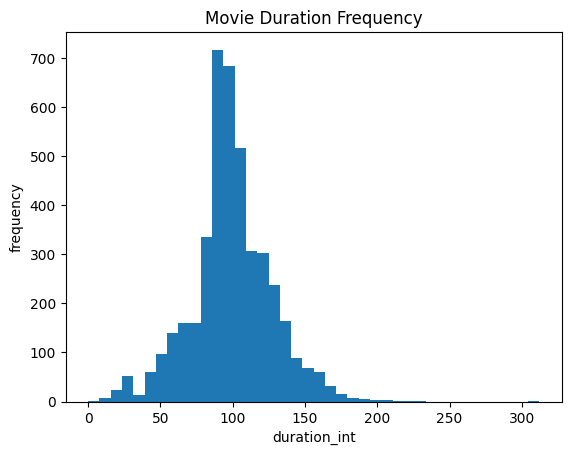

In [ ]:
# Histogram

df_movie = df.query('type == "Movie"')

ax = df_movie['duration_int'].plot(kind='hist',
                       bins=40,
                       title='Movie Duration Frequency')
ax.set_xlabel('duration_int')
ax.set_ylabel('frequency')

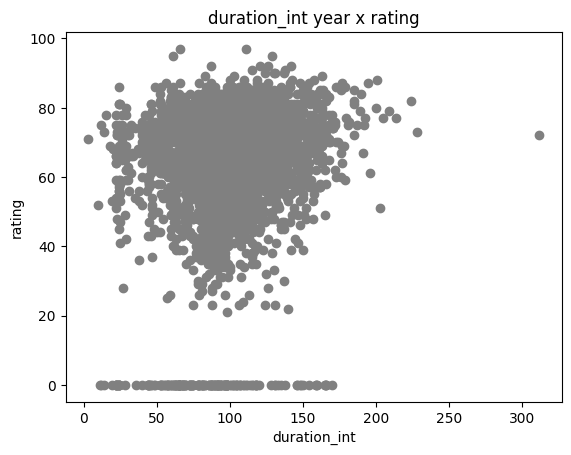

In [ ]:
# Create a scatter plot
plt.scatter(df_movie['duration_int'], df_movie['rating'], color='gray')

# Add labels and title
plt.xlabel('duration_int')
plt.ylabel('rating')
plt.title('duration_int x rating')

# Display the plot
plt.show()

In [ ]:
df_movie.describe()

,show_id,release_year,rating,duration_int
count,4.265000e+03,4264.000000,4264.000000,4265.000000
mean,7.562096e+07,2012.370310,62.352955,99.091442
std,1.287630e+07,9.679987,17.116029,28.101274
min,2.477470e+05,1942.000000,0.000000,0.000000
25%,7.030419e+07,2012.000000,57.000000,86.000000
50%,8.015858e+07,2016.000000,65.000000,98.000000
75%,8.099157e+07,2017.000000,73.000000,115.000000
max,8.123573e+07,2020.000000,97.000000,312.000000


In [ ]:
q1_movie, q2_movie, q3_movie = calculate_quartiles(df_movie['duration_int'])

print("Q1:", q1_movie)
print("Median (Q2):", q2_movie)
print("Q3:", q3_movie)

Q1: 86.0
Median (Q2): 98.0
Q3: 115.0


In [ ]:
    #df[new_column_name] = np.where(df[column_to_replace] == value_to_replace, 'New Value', df[column_to_replace])

df_teste = df.copy()
df_teste['duration_categ'] = np.where(df_teste['duration_int'] <= q1_movie, 'short', df_teste['duration_int'])
df_teste.loc[df_teste['duration_int'] > q1_movie, df_teste['duration_int']] = 'average'
#df_teste['duration_categ'] = np.where(df_teste['duration_int'] > q1_movie '''and df_teste['duration_int'] <= q2_movie''', 'average', df_teste['duration_int'])
#df_teste['duration_categ'] = np.where(df['duration_int'] <= q3_movie, 'short', df['duration_int'])
#df_teste['duration_categ'] = np.where(df['duration_int'] > q3_movie, 'short', df['duration_int'])

df_teste.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,6,9,9,9,9,9,9,9,13,13
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019.0,41.0,90 min,...,average,average,average,average,average,average,average,average,average,average
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016.0,52.0,94 min,...,average,average,average,average,average,average,average,average,average,average
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013.0,82.0,1 Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016.0,64.0,1 Season,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017.0,57.0,99 min,...,average,average,average,average,average,average,average,average,average,average


Text(0, 0.5, 'frequency')

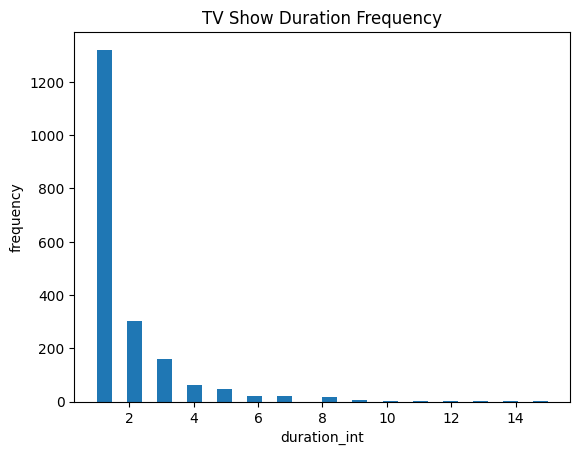

In [ ]:
# Histogram

df_tv_show = df.query('type == "TV Show"')

ax = df_tv_show['duration_int'].plot(kind='hist',
                       bins=30,
                       title='TV Show Duration Frequency')
ax.set_xlabel('duration_int')
ax.set_ylabel('frequency')

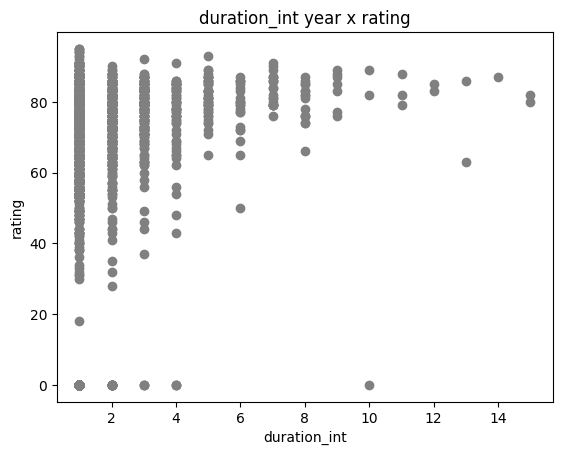

In [ ]:
# Create a scatter plot
plt.scatter(df_tv_show['duration_int'], df_tv_show['rating'], color='gray')

# Add labels and title
plt.xlabel('duration_int')
plt.ylabel('rating')
plt.title('duration_int year x rating')

# Display the plot
plt.show()

# dica de visualização fazer média com gráfico de barra

In [ ]:
df_tv_show.describe()

,show_id,release_year,rating,duration_int
count,1.969000e+03,1969.000000,1969.000000,1969.000000
mean,7.904892e+07,2015.536313,67.970543,1.779584
std,3.462549e+06,5.799568,22.105327,1.624936
min,6.003679e+07,1925.000000,0.000000,1.000000
25%,8.009178e+07,2015.000000,65.000000,1.000000
50%,8.017572e+07,2017.000000,75.000000,1.000000
75%,8.023986e+07,2018.000000,81.000000,2.000000
max,8.123560e+07,2020.000000,95.000000,15.000000


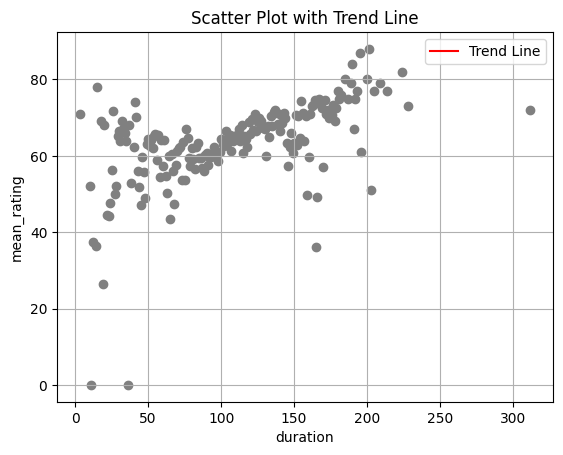

In [ ]:
# Dispersão com linha de tendência

df_movie_mean = df_movie.groupby('duration_int')['rating'].mean()
df_movie_mean = df_movie_mean.reset_index()

# Create a scatter plot
plt.scatter(df_movie_mean['duration_int'], df_movie_mean['rating'], color='gray')

# Fit a linear regression line to the data
slope, intercept = np.polyfit(df_movie_mean['duration_int'], df_movie_mean['rating'], 1)
trendline = slope * df_movie_mean['duration_int'] + intercept

# Plot the trend line
plt.plot(df_movie_mean['duration_int'], trendline, color='red', label='Trend Line')

# Customize the plot
plt.xlabel('duration')
plt.ylabel('mean_rating')
plt.title('Scatter Plot with Trend Line')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

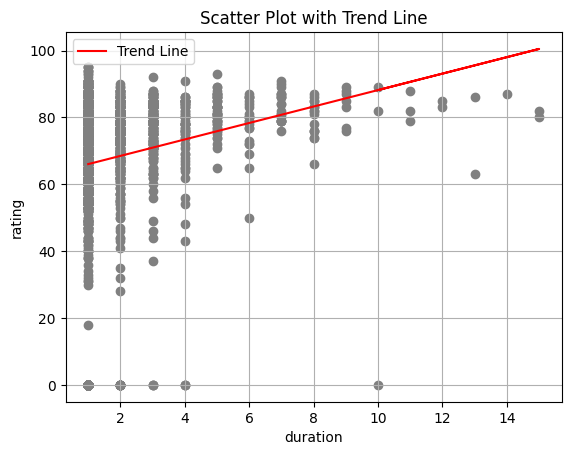

In [ ]:
# Dispersão com linha de tendência

# Create a scatter plot
plt.scatter(df_tv_show['duration_int'], df_tv_show['rating'], color='gray')

# Fit a linear regression line to the data
slope, intercept = np.polyfit(df_tv_show['duration_int'], df_tv_show['rating'], 1)
trendline = slope * df_tv_show['duration_int'] + intercept

# Plot the trend line
plt.plot(df_tv_show['duration_int'], trendline, color='red', label='Trend Line')

# Customize the plot
plt.xlabel('duration')
plt.ylabel('rating')
plt.title('Scatter Plot with Trend Line')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

## Variable | Release Year

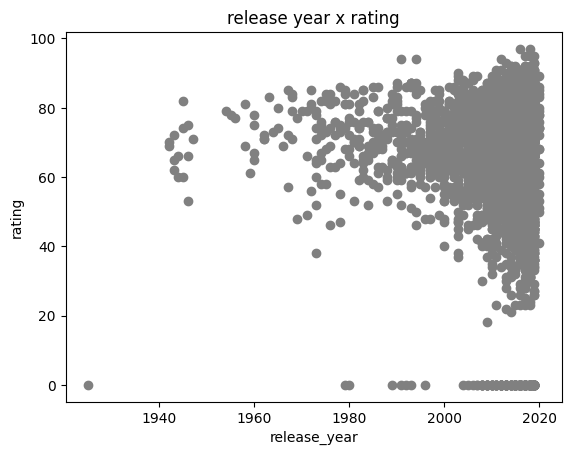

In [ ]:
# Create a scatter plot
plt.scatter(df['release_year'], df['rating'], color='gray')

# Add labels and title
plt.xlabel('release_year')
plt.ylabel('rating')
plt.title('release year x rating')

# Display the plot
plt.show()

Text(0, 0.5, 'frequency')

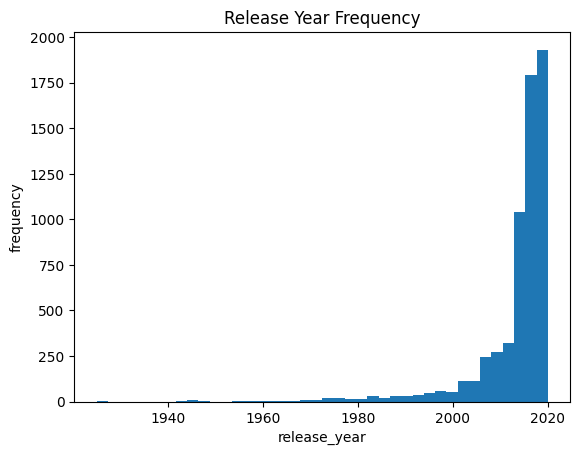

In [ ]:
# Histogram

#df_movie = df.query('type == "Movie"')

ax = df['release_year'].plot(kind='hist',
                       bins=40,
                       title='Release Year Frequency')
ax.set_xlabel('release_year')
ax.set_ylabel('frequency')

In [ ]:
q1_movie, q2_movie, q3_movie = calculate_quartiles(df['release_year'])

print("Q1:", q1_movie)
print("Median (Q2):", q2_movie)
print("Q3:", q3_movie)

Q1: 2013.0
Median (Q2): 2016.0
Q3: 2018.0


In [ ]:
if (df['show_id'] == 80119194).any():
    df.loc[df['show_id'] == 80119194, 'release_year'] = 2013

In [ ]:
df.isnull().sum()

show_id            0
type               0
title              0
director        1970
cast               1
country            1
date_added        12
release_year       0
rating             1
duration           1
listed_in          1
description        1
dtype: int64

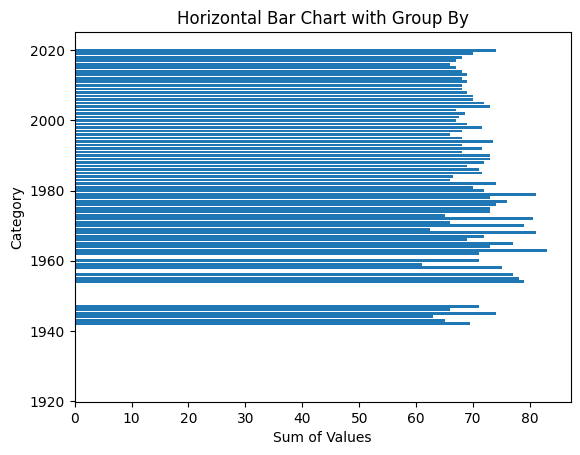

In [ ]:
# Horizontal bar chart of release year x rating

mean_release_yaer_rating = df.groupby('release_year')['rating'].median()

# Create a figure and axis
fig, ax = plt.subplots()

# Create a horizontal bar chart
ax.barh(mean_release_yaer_rating.index, mean_release_yaer_rating.values)

# Set labels and title
ax.set_xlabel('Sum of Values')
ax.set_ylabel('Category')
ax.set_title('Horizontal Bar Chart with Group By')

# Show the plot
plt.show()

## Variable | Country

In [ ]:
df_country = df.copy()
df_country = split_explode(df_country, 'country')
df_country.groupby('country')['rating'].mean().sort_values(ascending=False)

country
United Kingdom,    84.000000
Mauritius          83.000000
Cuba               81.000000
Bermuda            81.000000
Ecuador            81.000000
                     ...    
Egypt              52.240741
none               43.392857
Kazakhstan         43.000000
Iraq               38.500000
Nepal              27.500000
Name: rating, Length: 114, dtype: float64

In [ ]:
# Selecting the countries that have more than the mean quantity of titles

df_country_count = df_country.groupby('country')['rating'].count().sort_values(ascending=False)
df_country_count = df_country_count.reset_index()
df_country_count = df_country_count.rename(columns={'rating': 'count'})

mean_df_country_count = df_country_count['count'].mean()

countries_ge_mean_count = df_country_count.loc[df_country_count['count'] >= mean_df_country_count]

In [ ]:
df_country_mean = df_country.groupby('country')['rating'].mean().sort_values(ascending=False)
df_country_mean = df_country_mean.reset_index()
df_country_mean = df_country_mean.rename(columns={'rating': 'mean'})

In [ ]:
# Table with the countries that have more titles than the average and its mean rating

df_country_mean_and_count = countries_ge_mean_count.merge(df_country_mean, on='country', how='left')

# Sort the DataFrame by 'Age' in descending order
df_country_mean_and_count = df_country_mean_and_count.sort_values(by='mean', ascending=False)

# Reindex the DataFrame
df_country_mean_and_count = df_country_mean_and_count.reset_index(drop=True)

In [ ]:
top_5_countries = df_country_mean_and_count.head(5).copy()
bottom_5_countries = df_country_mean_and_count.tail(5).copy()

In [ ]:
top_5_countries.head()

,country,count,mean
0,Japan,231,70.727273
1,South Korea,162,68.537037
2,Australia,126,67.682540
3,United Kingdom,601,67.494176
4,Taiwan,75,66.746667


In [ ]:
# Perform left join and return True or False based on match
df_country = df_country.merge(countries_ge_mean_count, on='country', how='left', indicator=True)
df_country['Match'] = df_country['_merge'] == 'both'

# Drop unnecessary columns
df_country.drop(['_merge'], axis=1, inplace=True)

# Display the resulting DataFrame
df_country.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,count,Match
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...",United States,2019-09-09,2019.0,41.0,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2608.0,True
1,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...",India,2019-09-09,2019.0,41.0,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,838.0,True
2,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...",South Korea,2019-09-09,2019.0,41.0,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,162.0,True
3,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...",China,2019-09-09,2019.0,41.0,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,120.0,True
4,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016.0,52.0,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,601.0,True


In [ ]:
deduplicated_df_country = df_country.drop_duplicates(subset=['show_id'])
deduplicated_df_country

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,count,Match
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...",United States,2019-09-09,2019.0,41.0,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2608.0,True
4,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016.0,52.0,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,601.0,True
5,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013.0,82.0,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2608.0,True
6,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016.0,64.0,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,2608.0,True
7,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017.0,57.0,99 min,Comedies,When nerdy high schooler Dani finally attracts...,2608.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7650,80000063,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaT,2015.0,86.0,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil...",2608.0,True
7651,70286564,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaT,2016.0,78.0,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews...",2608.0,True
7652,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,bam,none,NaT,2016.0,62.0,60 min,Movies,Nursery rhymes and original music for children...,476.0,True
7653,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaT,2013.0,81.0,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ...",601.0,True


# **Data preprocessing**:

This involves **cleaning** the dataset, handling **missing values**, handling **outliers**, and performing any necessary data **transformations** or **normalization**

In [5]:
df.isnull().sum()

show_id            0
type               0
title              0
director        1970
cast               1
country            1
date_added        12
release_year       1
rating             1
duration           1
listed_in          1
description        1
dtype: int64

In [6]:
df['rating'] = df['rating'].fillna(0)

In [7]:
df.isnull().sum()

show_id            0
type               0
title              0
director        1970
cast               1
country            1
date_added        12
release_year       1
rating             0
duration           1
listed_in          1
description        1
dtype: int64

# **Splitting the dataset**:

Once the data preprocessing and feature engineering steps are complete, you should split the dataset into **training** and **testing** sets. The purpose of this split is to evaluate the performance of the trained model on unseen data

In [8]:
split_ratio = 0.8
train_df = df.sample(frac=split_ratio, random_state=42)
test_df = df.drop(train_df.index)

# **Feature Engineering**:

This step involves selecting **relevant** features, **creating new features**, and **encoding** categorical variables if needed. The goal is to extract the most informative features for the model

In [ ]:
'''
show_id - retirar no final
type - OK
title - ?
director - OK
cast - OK
country - OK
date_added - ?
release_year - OK
rating - OK (boa prática de normalizar e depois voltar para o original)
duration - OK
listed_in - ?
description - ?
'''

## Variable | Type

In [9]:
train_df = categ_binary(train_df, 'type')
test_df = categ_binary(test_df, 'type')

## Variable | Director

In [10]:
# Split and Explode function

train_df_director = train_df.copy()
train_df_director = split_explode(train_df_director, 'director')

test_df_director = test_df.copy()
test_df_director = split_explode(test_df_director, 'director')

In [11]:
# Target Encoding Train Dataset

train_df_director_target_encoding = train_df_director.copy()
train_df_director_target_encoding = target_encoding(train_df_director_target_encoding, 'director')
train_df_director_mean = train_df_director_target_encoding[['show_id','director']]
train_df_director_mean = train_df_director_mean.groupby('show_id').agg({'director': 'mean'})
train_df = pd.merge(train_df, train_df_director_mean, on='show_id', how='left')

In [12]:
# Mean Train Dataset (director | mean)

train_df = train_df.rename(columns={'director_x': 'director'})

train_df_director_te_mean = split_explode(train_df, 'director')
mean_director_rating_train_df = train_df_director_te_mean.groupby('director')['rating'].mean()
mean_director_rating_train_df

director
A. L. Vijay         59.500000
A. Salaam           58.000000
A.R. Murugadoss     76.666667
Aadish Keluskar     63.000000
Aamir Bashir        69.000000
                      ...    
Álvaro Longoria     64.000000
Çagan Irmak         84.000000
Éric Warin          70.000000
Ömer Faruk Sorak    80.000000
Şenol Sönmez        57.500000
Name: rating, Length: 3025, dtype: float64

In [13]:
test_df_director = pd.merge(test_df_director, mean_director_rating_train_df, on='director', how='left')
test_df_director = test_df_director[['show_id','rating_y']]
test_df_director = test_df_director.rename(columns={'rating_y': 'director_y'})

test_df_director_mean = test_df_director.groupby('show_id').agg({'director_y': 'mean'})
test_df = pd.merge(test_df, test_df_director_mean, on='show_id', how='left')

In [14]:
# handle unseen values on the test dataset
test_df.isnull().sum()

show_id           0
type              0
title             0
director        387
cast              1
country           1
date_added        3
release_year      1
rating            0
duration          1
listed_in         1
description       1
director_y      949
dtype: int64

In [15]:
mean_rating_train_all = train_df['rating'].mean()

train_df['director_y'] = train_df['director_y'].replace(0, mean_rating_train_all)
train_df['director_y'] = train_df['director_y'].fillna(mean_rating_train_all)

In [16]:
mean_rating_test_all = test_df['rating'].mean()

test_df['director_y'] = test_df['director_y'].replace(0, mean_rating_test_all)
test_df['director_y'] = test_df['director_y'].fillna(mean_rating_test_all)

In [17]:
# normalização / padronização?

train_df['director_norm'] = normalize(train_df, 'director_norm','director_y')
test_df['director_norm'] = normalize(test_df, 'director_norm', 'director_y')

## Variable | Cast

In [18]:
# Split and Explode function

train_df_cast = train_df.copy()
train_df_cast = split_explode(train_df_cast, 'cast')

test_df_cast = test_df.copy()
test_df_cast = split_explode(test_df_cast, 'cast')

In [19]:
# Target Encoding Train Dataset

train_df_cast_target_encoding = train_df_cast.copy()
train_df_cast_target_encoding = target_encoding(train_df_cast_target_encoding, 'cast')
train_df_cast_mean = train_df_cast_target_encoding[['show_id','cast']]
train_df_cast_mean = train_df_cast_mean.groupby('show_id').agg({'cast': 'mean'})
train_df = pd.merge(train_df, train_df_cast_mean, on='show_id', how='left')

In [20]:
# Mean Train Dataset (cast | mean)

train_df = train_df.rename(columns={'cast_x': 'cast'})

train_df_cast_te_mean = split_explode(train_df, 'cast')
mean_cast_rating_train_df = train_df_cast_te_mean.groupby('cast')['rating'].mean()
mean_cast_rating_train_df

cast
2 Chainz                   74.000000
4Minute                    59.000000
50 Cent                    51.333333
A Boogie Wit tha Hoodie    74.000000
A-ra Go                    84.000000
                             ...    
Şenay Bozoklar             60.000000
Şenay Gürler               76.000000
Şerif Sezer                84.000000
Şinasi Yurtsever           67.500000
Şükrü Özyıldız             76.000000
Name: rating, Length: 23378, dtype: float64

In [21]:
test_df_cast = pd.merge(test_df_cast, mean_cast_rating_train_df, on='cast', how='left')
test_df_cast = test_df_cast[['show_id','rating_y']]
test_df_cast = test_df_cast.rename(columns={'rating_y': 'cast_y'})

test_df_cast_mean = test_df_cast.groupby('show_id').agg({'cast_y': 'mean'})
test_df = pd.merge(test_df, test_df_cast_mean, on='show_id', how='left')

In [22]:
# handle unseen values on the test dataset
train_df.isnull().sum()

show_id             0
type                0
title               0
director         1583
cast                0
country             0
date_added          9
release_year        0
rating              0
duration            0
listed_in           0
description         0
director_y          0
director_norm       0
cast_y              0
dtype: int64

In [23]:
mean_rating_train_all = train_df['rating'].mean()

train_df['cast_y'] = train_df['cast_y'].replace(0, mean_rating_train_all)
train_df['cast_y'] = train_df['cast_y'].fillna(mean_rating_train_all)

In [24]:
mean_rating_test_all = test_df['rating'].mean()

test_df['cast_y'] = test_df['cast_y'].replace(0, mean_rating_test_all)
test_df['cast_y'] = test_df['cast_y'].fillna(mean_rating_test_all)

In [25]:
# normalização / padronização?

train_df['cast_norm'] = normalize(train_df, 'cast_norm','cast_y')
test_df['cast_norm'] = normalize(test_df, 'cast_norm', 'cast_y')

## Variable | Country

In [26]:
df_country = df.copy()
df_country = split_explode(df_country, 'country')
df_country.groupby('country')['rating'].mean().sort_values(ascending=False)

country
United Kingdom,    84.000000
Mauritius          83.000000
Cuba               81.000000
Bermuda            81.000000
Ecuador            81.000000
                     ...    
Egypt              52.240741
none               43.392857
Kazakhstan         43.000000
Iraq               38.500000
Nepal              27.500000
Name: rating, Length: 114, dtype: float64

In [27]:
# Selecting the countries that have more than the mean quantity of titles

df_country_count = df_country.groupby('country')['rating'].count().sort_values(ascending=False)
df_country_count = df_country_count.reset_index()
df_country_count = df_country_count.rename(columns={'rating': 'count'})

mean_df_country_count = df_country_count['count'].mean()

countries_ge_mean_count = df_country_count.loc[df_country_count['count'] >= mean_df_country_count]

In [28]:
df_country_mean = df_country.groupby('country')['rating'].mean().sort_values(ascending=False)
df_country_mean = df_country_mean.reset_index()
df_country_mean = df_country_mean.rename(columns={'rating': 'mean'})

In [29]:
# Table with the countries that have more titles than the average and its mean rating

df_country_mean_and_count = countries_ge_mean_count.merge(df_country_mean, on='country', how='left')

# Sort the DataFrame by 'Age' in descending order
df_country_mean_and_count = df_country_mean_and_count.sort_values(by='mean', ascending=False)

# Reindex the DataFrame
df_country_mean_and_count = df_country_mean_and_count.reset_index(drop=True)

In [30]:
top_5_countries = df_country_mean_and_count.head(5).copy()
bottom_5_countries = df_country_mean_and_count.tail(5).copy()

In [31]:
# converting the countries column to a list
list_countries = top_5_countries.country.to_list()
list_countries

['Japan', 'South Korea', 'Australia', 'United Kingdom', 'Taiwan']

In [ ]:
#top_and_bottom_countries = pd.concat([top_5_countries, bottom_5_countries], axis=0)

In [32]:
# For each country in the country list, create a column with the country's name
# The "apply" function works for every row in the dataframe
for country in list_countries:
    col_name = f'country_{country.lower()}'
    train_df[col_name] = train_df['country'].apply(contains_country, country=country)

In [33]:
test_df.isnull().sum()

show_id            0
type               0
title              0
director         387
cast               1
country            1
date_added         3
release_year       1
rating             0
duration           1
listed_in          1
description        1
director_y         0
director_norm      0
cast_y             0
cast_norm          0
dtype: int64

In [34]:
test_df = test_df[test_df.country.notnull()]

In [35]:
test_df.isnull().sum()

show_id            0
type               0
title              0
director         386
cast               0
country            0
date_added         2
release_year       0
rating             0
duration           0
listed_in          0
description        0
director_y         0
director_norm      0
cast_y             0
cast_norm          0
dtype: int64

In [36]:
for country in list_countries:
    col_name = f'country_{country.lower()}'
    test_df[col_name] = test_df['country'].apply(contains_country, country=country)

## Variable | Release Year

In [ ]:
'''# transform date into date ranges

train_df['release_year_range'] = date_range(train_df, 'release_year', 'release_year_range')
test_df['release_year_range'] = date_range(test_df, 'release_year', 'release_year_range')'''

In [ ]:
'''# Give a number value to each category

le = LabelEncoder()

train_df['release_year_range_encoded'] = le.fit_transform(train_df.release_year_range)
test_df['release_year_range_encoded'] = le.fit_transform(test_df.release_year_range)'''

In [37]:
# one-hot encoding para release_year <= 1980

# Using np.where()
train_df['old_release_year'] = np.where(train_df['release_year'] <= 1980, 1, 0)
test_df['old_release_year'] = np.where(test_df['release_year'] <= 1980, 1, 0)

# Using df.loc
train_df.loc[train_df['release_year'] <= 1980, 'Binary'] = 1
train_df.loc[train_df['release_year'] > 1980, 'Binary'] = 0

test_df.loc[test_df['release_year'] <= 1980, 'Binary'] = 1
test_df.loc[test_df['release_year'] > 1980, 'Binary'] = 0

## Variable | Duration

In [38]:
train_df = train_df[['type','director_norm','cast_norm','old_release_year','country_japan','country_south korea','country_australia','country_united kingdom','country_taiwan','duration','rating']]
test_df = test_df[['type','director_norm','cast_norm','old_release_year','country_japan','country_south korea','country_australia','country_united kingdom','country_taiwan','duration','rating']]

In [39]:
# Splitting the duration into int and string

train_df['duration_int'] = train_df.duration.str.split().str.get(0)
train_df['duration_str'] = train_df.duration.str.split().str.get(1)

test_df['duration_int'] = test_df.duration.str.split().str.get(0)
test_df['duration_str'] = test_df.duration.str.split().str.get(1)

In [40]:
test_df.isnull().sum()

type                      0
director_norm             0
cast_norm                 0
old_release_year          0
country_japan             0
country_south korea       0
country_australia         0
country_united kingdom    0
country_taiwan            0
duration                  0
rating                    0
duration_int              0
duration_str              0
dtype: int64

In [41]:
if (train_df['show_id'] == 80119194).any():
    train_df.loc[train_df['show_id'] == 80119194, 'duration_int'] = 0

if (test_df['show_id'] == 80119194).any():
    test_df.loc[test_df['show_id'] == 80119194, 'duration_int'] = 0

train_df['duration_int'].fillna(0)
test_df['duration_int'].fillna(0)

KeyError: ignored

In [42]:
train_df['duration_int'] = train_df['duration_int'].astype(int)
test_df['duration_int'] = test_df['duration_int'].astype(int)

In [43]:
# Splitting the dataframe into Movie and TV Show (train)

condition = train_df['type'] == 0

train_df_movie = train_df[condition]  # DataFrame satisfying the condition
train_df_tvshow = train_df[~condition]

In [44]:
train_df_tvshow.head()

,type,director_norm,cast_norm,old_release_year,country_japan,country_south korea,country_australia,country_united kingdom,country_taiwan,duration,rating,duration_int,duration_str
0,1,0.582819,0.654275,0,0,0,0,0,0,1 Season,67.0,1,Season
1,1,0.582819,0.627422,0,0,0,0,0,0,2 Seasons,60.0,2,Seasons
2,1,0.582819,0.758120,0,0,0,0,0,0,1 Season,72.0,1,Season
6,1,0.582819,0.654275,0,0,0,0,0,0,3 Seasons,79.0,3,Seasons
7,1,0.582819,0.715969,0,0,1,0,0,0,2 Seasons,79.0,2,Seasons


In [45]:
# Splitting the dataframe into Movie and TV Show (test)

condition = test_df['type'] == 0

test_df_movie = test_df[condition]  # DataFrame satisfying the condition
test_df_tvshow = test_df[~condition]

In [46]:
# Encoding separetly movie and tv show

train_df_movie['duration_range'] = duration_range_movie(train_df_movie, 'duration_int', 'duration_range')
train_df_tvshow['duration_range'] = duration_range_tvshow(train_df_tvshow, 'duration_int', 'duration_range')

test_df_movie['duration_range'] = duration_range_movie(test_df_movie, 'duration_int', 'duration_range')
test_df_tvshow['duration_range'] = duration_range_tvshow(test_df_tvshow, 'duration_int', 'duration_range')

In [47]:
# Give a number value to each category

le = LabelEncoder()

train_df_movie['duration_range_encoded'] = le.fit_transform(train_df_movie.duration_range)
train_df_tvshow['duration_range_encoded'] = le.fit_transform(train_df_tvshow.duration_range)

test_df_movie['duration_range_encoded'] = le.fit_transform(test_df_movie.duration_range)
test_df_tvshow['duration_range_encoded'] = le.fit_transform(test_df_tvshow.duration_range)

In [48]:
# Union train_df = train_df_movie + train_df_tvshow

train_df = pd.concat([train_df_movie, train_df_tvshow])
test_df = pd.concat([test_df_movie, test_df_tvshow])

In [49]:
train_df = train_df[['type','director_norm','cast_norm','old_release_year','country_japan','country_south korea','country_australia','country_united kingdom','country_taiwan','duration_range_encoded','rating']]
test_df = test_df[['type','director_norm','cast_norm','old_release_year','country_japan','country_south korea','country_australia','country_united kingdom','country_taiwan','duration_range_encoded','rating']]

## Variable | Listed In

In [ ]:
# Split and Explode function

df4 = df.copy()
df4 = split_explode(df4, 'listed_in')
df4

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019.0,41.0,90 min,Children & Family Movies,Before planning an awesome wedding for his gra...
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019.0,41.0,90 min,Comedies,Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016.0,52.0,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013.0,82.0,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016.0,64.0,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
...,...,...,...,...,...,...,...,...,...,...,...,...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaT,2013.0,81.0,2 Seasons,British TV Shows,"Set during the Russian Revolution, this comic ..."
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaT,2013.0,81.0,2 Seasons,TV Comedies,"Set during the Russian Revolution, this comic ..."
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaT,2013.0,81.0,2 Seasons,TV Dramas,"Set during the Russian Revolution, this comic ..."
6233,70153404,TV Show,Friends,NaN,"Jennifer Aniston, Courteney Cox, Lisa Kudrow, ...",United States,NaT,2003.0,89.0,10 Seasons,Classic & Cult TV,This hit sitcom follows the merry misadventure...


In [ ]:
# Descriptive statistics

df_listed_in_rating = df4.groupby('listed_in')['rating'].agg(['mean','median','count']).sort_values('count', ascending=False).head(10)
print(df_listed_in_rating)

                             mean  median  count
listed_in                                       
International Movies    62.755060    66.0   1927
Dramas                  65.561922    68.0   1623
Comedies                60.452830    62.0   1113
International TV Shows  66.625375    75.0   1001
Documentaries           65.326837    71.0    667
TV Dramas               68.547579    76.0    599
Action & Adventure      61.718593    64.0    597
Independent Movies      64.818841    66.0    552
TV Comedies             66.823394    74.0    436
Thrillers               60.770408    62.0    392


In [ ]:
# Give a number value to each category

le = LabelEncoder()
df4['Listed In Encoded'] = le.fit_transform(df4.listed_in)

# get unique values of two columns
unique_values = df4[['listed_in', 'Listed In Encoded']].drop_duplicates()

# print the unique values
print(unique_values)

                         listed_in  Listed In Encoded
0         Children & Family Movies                  4
0                         Comedies                  7
1                  Stand-Up Comedy                 30
2                         Kids' TV                 18
5                   Crime TV Shows                  8
5           International TV Shows                 17
5        Spanish-Language TV Shows                 28
6             International Movies                 16
6                 Sci-Fi & Fantasy                 26
6                        Thrillers                 41
8                       Docuseries                 11
8              Science & Nature TV                 27
9               Action & Adventure                  0
11                          Dramas                 12
19                     Cult Movies                  9
19              Independent Movies                 15
20                 Romantic Movies                 24
22                   Documen

In [ ]:
# One hot encode the categorical variable
one_hot_df = pd.get_dummies(df4['listed_in'])

# Print the resulting DataFrame
one_hot_df_int = one_hot_df.astype(int)

# Appending column
df_teste = pd.concat([df, one_hot_df_int], axis=1)

df_teste.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019.0,41.0,90 min,...,0,0,0,0,0,0,0,0,0,0
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019.0,41.0,90 min,...,0,0,0,0,0,0,0,0,0,0
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016.0,52.0,94 min,...,0,0,0,0,0,0,0,0,0,0
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013.0,82.0,1 Season,...,0,0,0,0,0,0,0,0,0,0
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016.0,64.0,1 Season,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_teste.corr()

<ipython-input-8-0c3859c83909>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_teste.corr()


,show_id,release_year,rating,Action & Adventure,Anime Features,Anime Series,British TV Shows,Children & Family Movies,Classic & Cult TV,Classic Movies,...,TV Action & Adventure,TV Comedies,TV Dramas,TV Horror,TV Mysteries,TV Sci-Fi & Fantasy,TV Shows,TV Thrillers,Teen TV Shows,Thrillers
show_id,1.000000,0.581380,-0.094226,-0.113051,-0.003254,0.008329,0.023798,-0.036539,-0.016827,-0.218597,...,0.015600,0.038369,0.047304,0.005840,0.010872,0.009754,0.009236,0.010038,0.014574,-0.021430
release_year,0.581380,1.000000,-0.067297,-0.101489,-0.014430,0.001506,0.024232,-0.022811,-0.063195,-0.354255,...,0.030561,0.048981,0.071536,0.028433,0.033787,0.008125,-0.053028,0.022997,0.022564,0.008958
rating,-0.094226,-0.067297,1.000000,-0.031908,0.000113,0.052339,0.024685,-0.070890,0.034948,0.034382,...,0.054386,0.021920,0.045381,0.025038,0.032915,0.029444,-0.019097,0.025364,0.025706,-0.034274
Action & Adventure,-0.113051,-0.101489,-0.031908,1.000000,-0.012282,-0.019857,-0.026694,-0.036040,-0.008963,-0.016704,...,-0.020613,-0.038791,-0.045750,-0.013459,-0.015222,-0.015111,-0.005782,-0.012144,-0.012144,-0.036721
Anime Features,-0.003254,-0.014430,0.000113,-0.012282,1.000000,-0.005340,-0.007179,-0.009692,-0.002410,-0.004492,...,-0.005543,-0.010432,-0.012304,-0.003619,-0.004094,-0.004064,-0.001555,-0.003266,-0.003266,-0.009875
Anime Series,0.008329,0.001506,0.052339,-0.019857,-0.005340,1.000000,-0.011606,-0.015670,-0.003897,-0.007262,...,-0.008962,-0.016866,-0.019891,-0.005852,-0.006618,-0.006570,-0.002514,-0.005280,-0.005280,-0.015966
British TV Shows,0.023798,0.024232,0.024685,-0.026694,-0.007179,-0.011606,1.000000,-0.021065,-0.005239,-0.009763,...,-0.012048,-0.022673,-0.026741,-0.007867,-0.008897,-0.008832,-0.003380,-0.007098,-0.007098,-0.021463
Children & Family Movies,-0.036539,-0.022811,-0.070890,-0.036040,-0.009692,-0.015670,-0.021065,1.000000,-0.007073,-0.013181,...,-0.016267,-0.030611,-0.036103,-0.010621,-0.012012,-0.011924,-0.004563,-0.009584,-0.009584,-0.028977
Classic & Cult TV,-0.016827,-0.063195,0.034948,-0.008963,-0.002410,-0.003897,-0.005239,-0.007073,1.000000,-0.003278,...,-0.004045,-0.007613,-0.008978,-0.002641,-0.002987,-0.002965,-0.001135,-0.002383,-0.002383,-0.007206
Classic Movies,-0.218597,-0.354255,0.034382,-0.016704,-0.004492,-0.007262,-0.009763,-0.013181,-0.003278,1.000000,...,-0.007539,-0.014188,-0.016733,-0.004922,-0.005567,-0.005527,-0.002115,-0.004442,-0.004442,-0.013430


In [ ]:
df_teste.corr().to_excel('output.xlsx', index=False)

<ipython-input-9-cd7c273d024d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_teste.corr().to_excel('output.xlsx', index=False)



# **Splitting the dataset**:

Once the data preprocessing and feature engineering steps are complete, you should split the dataset into **training** and **testing** sets. The purpose of this split is to evaluate the performance of the trained model on unseen data

In [50]:
# tem apenas 1 linha com rating NA que precisamos transformar em zero
train_df = train_df.dropna()
test_df = test_df.dropna()

In [55]:
'''
- talvez retirar rating = 0, está afetando performance (só retirar base de treino?)
'''
train_df = train_df[train_df['rating'] != 0]
test_df = test_df[test_df['rating'] != 0]

In [ ]:
'''
train_df_vf = train_df[['type','director_norm','cast_norm','old_release_year','rating']].copy()
test_df_vf = test_df[['type','director_norm','cast_norm','old_release_year','rating']].copy()
'''

In [ ]:
#train_df_vf.head()

,type,director_norm,cast_norm,old_release_year,rating
3,0,0.518987,0.610694,0,59.0
4,0,0.531646,0.664975,0,60.0
5,0,0.594937,0.689518,1,65.0
8,0,0.405063,0.615171,0,50.0
12,0,0.438819,0.623385,0,55.0


In [56]:
X_train = train_df.drop('rating', axis=1)
y_train = train_df['rating']

X_test = test_df.drop('rating', axis=1)
y_test = test_df['rating']

In [ ]:
X_train.head(2)

,type,director_norm,cast_norm,old_release_year,country_japan,country_south korea,country_australia,country_united kingdom,country_taiwan,duration_range_encoded
3,0,0.518987,0.610694,0,0,0,0,0,0,1
4,0,0.531646,0.664975,0,0,0,0,0,0,2


In [57]:
y_train.head(2)

3    59.0
4    60.0
Name: rating, dtype: float64

# **Model training**:

After the dataset is split, the training set is used to **train the machine learning model**. This step involves **selecting an appropriate model**, defining the model architecture or algorithm, and fitting the model to the training data

## Multiple Linear Regression

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print(mse)

335.36198642329396


In [ ]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(mape)

inf


<ipython-input-136-4c38cdf1a055>:90: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


## Multiple Models simultaneously

In [58]:
models = {
    'Lasso': linear_model.Lasso(), #(muitas variáveis, que trata multicolinearidade, previne overfitting)
    'Ridge': linear_model.BayesianRidge(), #(muitas variáveis, que trata multicolinearidade)
    'SVM': svm.SVR(),
    'Decision Tree Regressor': tree.DecisionTreeRegressor(),
    'KNN': neighbors.KNeighborsRegressor(5),
    'LGBM': LGBMRegressor(objective='regression', random_seed=1),
    'Random Forest Regressor': RandomForestRegressor(),
    'XGB': xgb.XGBRegressor()#,
    #'Gradient Boosting': Gradient
}

In [59]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # X_train and y_train represent your training data
    y_pred = model.predict(X_test)  # X_test represents your test data
    mae = mean_absolute_error(y_test, y_pred)  # y_test represents the true values of the target variable
    #mape = mean_absolute_percentage_error(y_test, y_pred)
    results[name] = mae

# **Model Evaluation:**

Once the model is trained, it is evaluated on the testing set to assess its **performance** on unseen data. This step helps to estimate how well the model generalizes to new, unseen examples

## Evaluating the ML models

In [60]:
for name, mae in results.items():
    print(f"{name}: Mean Absolute Error = {mae}")

Lasso: Mean Absolute Error = 8.824659735844659
Ridge: Mean Absolute Error = 9.691324331143399
SVM: Mean Absolute Error = 8.880099433440854
Decision Tree Regressor: Mean Absolute Error = 11.021969696969697
KNN: Mean Absolute Error = 9.705555555555556
LGBM: Mean Absolute Error = 10.11739593551308
Random Forest Regressor: Mean Absolute Error = 10.539074706309183
XGB: Mean Absolute Error = 10.397942347157283


## Good or Bad parameter

In [61]:
# Parameter to tell if the MAE (evaluation metric) is good or bad
# replica uma coluna com a média de rating, e faz uma média desse delta (rating - rating médio)

mean_rating = df['rating'].mean()

df_parameter = df[['rating']].copy()
df_parameter['mean_rating'] = mean_rating

In [62]:
df_parameter['delta'] = df_parameter['mean_rating'] - df_parameter['rating']

In [63]:
df_parameter['delta'].mean()

-4.814457035371612e-15

In [64]:
df_parameter.describe()

,rating,mean_rating,delta
count,6234.000000,6234.00000,6.234000e+03
mean,64.117260,64.11726,-4.814457e-15
std,19.029709,0.00000,1.902971e+01
min,0.000000,64.11726,-3.288274e+01
25%,59.000000,64.11726,-1.188274e+01
50%,68.000000,64.11726,-3.882740e+00
75%,76.000000,64.11726,5.117260e+00
max,97.000000,64.11726,6.411726e+01


# **Model refinement and hyperparameter tuning**:

Based on the evaluation results, you **may need to refine** the model by adjusting **hyperparameters** or exploring different algorithms. This step aims to **optimize** the model's **performance**